In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import LlamaTokenizer, LlamaForCausalLM
import torch

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

/root/miniconda3/envs/robust/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Check for flash attention

In [2]:
model_id = "meta-llama/Llama-2-7b-chat-hf"
tokenizer = LlamaTokenizer.from_pretrained(model_id, truncation_side='left', padding_side='right')
tokenizer.pad_token = tokenizer.eos_token
# model = LlamaForCausalLM.from_pretrained(model_id, device_map={"":0},use_flash_attention_2=True)
model = LlamaForCausalLM.from_pretrained(model_id, device_map={"":0})
flash_attn_model = LlamaForCausalLM.from_pretrained(model_id, device_map={"":0},use_flash_attention_2=True)


KeyboardInterrupt: 

In [82]:
tokenizer = LlamaTokenizer.from_pretrained(model_id, truncation_side='left', padding_side='right')


In [76]:
model.eval()
flash_attn_model.eval()

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaFlashAttention2(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLUActivation()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )


In [94]:
tokenizer.pad_token = tokenizer.eos_token

input_prompt = "I've got a lovely bunch of coconuts do do do dooo"
random = " ".join(["do" for _ in range(50)])
batched_input_prompt = ["I've got a lovely bunch of coconuts do do do dooo", " ".join(["do" for _ in range(50)])]
input_prompt_tokenized = tokenizer(input_prompt, return_tensors="pt").to('cuda')
input_prompt_padded_tokenized = tokenizer(input_prompt, return_tensors="pt", padding="max_length", max_length=50).to('cuda')
batched_input_prompt_tokenized = tokenizer(batched_input_prompt, return_tensors="pt", padding=True, max_length=50).to('cuda')
random_tokenized = tokenizer(random, return_tensors="pt").to('cuda')

print(input_prompt_tokenized)
print(input_prompt_padded_tokenized)
print(batched_input_prompt_tokenized)

{'input_ids': tensor([[    1,   306, 29915,   345,  2355,   263, 12355,   873, 14928,   310,
          1302,   535,  8842,   437,   437,   437,   437,  3634]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
       device='cuda:0')}
{'input_ids': tensor([[    1,   306, 29915,   345,  2355,   263, 12355,   873, 14928,   310,
          1302,   535,  8842,   437,   437,   437,   437,  3634,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2,
             2,     2,     2,     2,     2,     2,     2,     2,     2,     2]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]], device='cuda:0')}
{'input_ids': tensor([[    1,   306, 29915,   345,  2355

/transformers/src/transformers/tokenization_utils_base.py:2630: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


In [84]:
input_ids_masked = torch.zeros(input_prompt_padded_tokenized.input_ids.shape, dtype=torch.int64).to('cuda')
torch.where(input_prompt_padded_tokenized.input_ids == tokenizer.pad_token_id,
            torch.tensor(-100, dtype=torch.int64),
            input_prompt_padded_tokenized.input_ids,
            out=input_ids_masked)

loss1 = model(
    input_prompt_tokenized.input_ids,
    attention_mask=input_prompt_tokenized.attention_mask,
    labels=input_prompt_tokenized.input_ids
).loss

logits1 = model(
    input_prompt_tokenized.input_ids,
    attention_mask=input_prompt_tokenized.attention_mask,
    labels=input_prompt_tokenized.input_ids
).logits

print(f"Normal Model + Non-Padded Input")
print(f"Loss (no padding): {loss1}")
print(f"Logits (no padding): {logits1}")

Normal Model + Non-Padded Input
Loss (no padding): 2.8300979137420654
Logits (no padding): tensor([[[ 0.1357, -0.1206,  0.3125,  ...,  1.3594,  1.8984,  0.6641],
         [-8.3750, -9.8125, -0.3691,  ..., -3.4844, -8.0000, -2.8594],
         [-3.7812, -2.7656,  4.0000,  ..., -1.4297, -2.8125, -0.3926],
         ...,
         [-3.4688, -3.0625,  8.3125,  ...,  0.2559, -2.6875, -2.8125],
         [-3.0000, -3.0938,  8.7500,  ...,  0.0806, -2.5156, -2.7656],
         [-2.6562, -1.6953,  7.7812,  ..., -0.6484, -3.1562, -2.5000]]],
       device='cuda:0', dtype=torch.float32, grad_fn=<ToCopyBackward0>)


In [96]:
loss1_falsh_attn = flash_attn_model(
    input_prompt_tokenized.input_ids,
    attention_mask=input_prompt_tokenized.attention_mask,
    labels=input_prompt_tokenized.input_ids
).loss

logits1_falsh_attn = flash_attn_model(
    input_prompt_tokenized.input_ids,
    attention_mask=input_prompt_tokenized.attention_mask,
    labels=input_prompt_tokenized.input_ids
).logits

loss_random = model(
    random_tokenized.input_ids,
    attention_mask=random_tokenized.attention_mask,
    labels=random_tokenized.input_ids
).loss

print(f"Flash Attn Model + Non-Padded Input")
print(f"Loss (no padding) with flash attn: {loss1_falsh_attn}")
print(f"Logits (no padding) with flash attn: {logits1_falsh_attn}")
print(f"Loss (no padding) with flash attn: {loss_random + loss1_falsh_attn}")

Flash Attn Model + Non-Padded Input
Loss (no padding) with flash attn: 2.8371522426605225
Logits (no padding) with flash attn: tensor([[[ 0.1357, -0.1206,  0.3125,  ...,  1.3594,  1.8984,  0.6641],
         [-8.4375, -9.8750, -0.3555,  ..., -3.5000, -8.0625, -2.9062],
         [-3.7812, -2.7812,  4.0625,  ..., -1.3828, -2.7969, -0.3438],
         ...,
         [-3.4844, -3.0781,  8.3750,  ...,  0.2871, -2.6719, -2.8125],
         [-3.0625, -3.1250,  8.6875,  ...,  0.0928, -2.5781, -2.7812],
         [-2.6562, -1.6719,  7.7812,  ..., -0.6914, -3.1406, -2.5156]]],
       device='cuda:0', dtype=torch.float32, grad_fn=<ToCopyBackward0>)
Loss (no padding) with flash attn: 8.834760665893555


In [105]:
loss2 = model(
    input_prompt_padded_tokenized.input_ids,
    attention_mask=input_prompt_padded_tokenized.attention_mask,
    labels=input_prompt_padded_tokenized.input_ids
).loss

logits2 = model(
    input_prompt_padded_tokenized.input_ids,
    attention_mask=input_prompt_padded_tokenized.attention_mask,
    labels=input_prompt_padded_tokenized.input_ids
).logits

print(logits2.shape)
# decode the logits
print(tokenizer.decode(logits2.argmax(dim=-1)[0]))

print(f"Normal Model + Padded Input")
print(f"Loss (padding): {loss2}")
print(f"Logits (padding): {logits2}")
print(f"Decoded Logits (padding): {decoded_logits}")

torch.Size([1, 50, 32000])
Unterscheidung'm been a bitely little of coconuts
o do do doo<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>'''
Normal Model + Padded Input
Loss (padding): 8.399846076965332
Logits (padding): tensor([[[ 0.1357, -0.1206,  0.3125,  ...,  1.3594,  1.8984,  0.6641],
         [-8.3750, -9.8125, -0.3691,  ..., -3.4844, -8.0000, -2.8594],
         [-3.7812, -2.7656,  4.0000,  ..., -1.4297, -2.8125, -0.3926],
         ...,
         [-4.9062,  8.0000,  5.2500,  ..., -2.2812, -2.2812, -2.7344],
         [-5.4062,  3.4219,  5.3125,  ..., -2.6094, -1.1250, -3.4062],
         [-5.3125,  2.5312,  5.9375,  ..., -2.2656, -0.9961, -3.6719]]],
       device='cuda:0', dtype=torch.float32, grad_fn=<ToCopyBackward0>)
Decoded Logits (padding): []


In [106]:
loss2_falsh_attn = flash_attn_model(
    input_prompt_padded_tokenized.input_ids,
    attention_mask=input_prompt_padded_tokenized.attention_mask,
    labels=input_prompt_padded_tokenized.input_ids
).loss

logits2_falsh_attn = flash_attn_model(
    input_prompt_padded_tokenized.input_ids,
    attention_mask=input_prompt_padded_tokenized.attention_mask,
    labels=input_prompt_padded_tokenized.input_ids
).logits

print(tokenizer.decode(logits2_falsh_attn.argmax(dim=-1)[0]))

print(f"Flash Attn Model + Padded Input")
print(f"Loss (padding) with flash attn: {loss2_falsh_attn}")
print(f"Logits (padding) with flash attn: {logits2_falsh_attn}")

Unterscheidung'm been a bitely little of coconuts
o do do doo<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
Flash Attn Model + Padded Input
Loss (padding) with flash attn: 16.86910057067871
Logits (padding) with flash attn: tensor([[[ 0.1357, -0.1206,  0.3125,  ...,  1.3594,  1.8984,  0.6641],
         [-8.4375, -9.8750, -0.3555,  ..., -3.5000, -8.0625, -2.9062],
         [-3.7812, -2.7812,  4.0625,  ..., -1.3828, -2.7969, -0.3438],
         ...,
         [ 8.5000, 27.0000,  2.2188,  ...,  4.2188,  1.9766,  3.6250],
         [ 8.5000, 27.0000,  2.2188,  ...,  4.2188,  1.9766,  3.6250],
         [ 8.5000, 27.0000,  2.2188,  ...,  4.2188,  1.9766,  3.6250]]],
       device='cuda:0', dtype=torch.float32, grad_fn=<ToCopyBackward0>)


In [113]:
loss2 = model(
    batched_input_prompt_tokenized.input_ids,
    attention_mask=batched_input_prompt_tokenized.attention_mask,
    labels=batched_input_prompt_tokenized.input_ids
).loss

logits2 = model(
    batched_input_prompt_tokenized.input_ids,
    attention_mask=batched_input_prompt_tokenized.attention_mask,
    labels=batched_input_prompt_tokenized.input_ids
).logits

print('Decoded Logits')
print('------------------')
print(tokenizer.decode(logits2.argmax(dim=-1)[0]))
print('------------------\n')

print(f"Normal Model + Padded Input")
print(f"Loss (with padding): {loss2}")
print(f"Logits (with padding): {logits2[0]}")

Decoded Logits
------------------
Unterscheidung'm been a bitely little of coconuts
o do do doo<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>''''
------------------

Normal Model + Padded Input
Loss (with padding): 7.247009754180908
Logits (with padding): tensor([[ 0.0608, -0.1953,  0.3203,  ...,  1.3281,  1.8359,  0.6094],
        [-8.3750, -9.8125, -0.3574,  ..., -3.5000, -8.0625, -2.8750],
        [-3.8281, -2.8281,  4.0000,  ..., -1.4375, -2.8438, -0.4102],
        ...,
        [-5.3438,  3.5625,  5.4062,  ..., -2.5781, -1.0469, -3.3594],
        [-5.3750,  2.4375,  5.8438,  ..., -2.2969, -1.0547, -3.7031],
        [-5.1250,  3.9844,  5.8750,  ..., -1.9766, -0.9297, -3.1250]],
       device='cuda:0', dtype=torch.float32, grad_fn=<SelectBackward0>)


In [114]:
flash_attn_loss = flash_attn_model(
    batched_input_prompt_tokenized.input_ids,
    attention_mask=batched_input_prompt_tokenized.attention_mask,
    labels=batched_input_prompt_tokenized.input_ids
).loss

flash_attn_logits = flash_attn_model(
    batched_input_prompt_tokenized.input_ids,
    attention_mask=batched_input_prompt_tokenized.attention_mask,
    labels=batched_input_prompt_tokenized.input_ids
).logits

print('Decoded Logits')
print('------------------')
print(tokenizer.decode(flash_attn_logits.argmax(dim=-1)[0]))
print('------------------\n')

print(f"Flash Attn Model + Padded Input")
print(f"Loss (padding input & masking labels): {flash_attn_loss}")
print(f"Logits (padding input & masking labels): {flash_attn_logits[0]}")

Decoded Logits
------------------
Unterscheidung'm been a bitely little of coconuts
o do do doo<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s>
------------------

Flash Attn Model + Padded Input
Loss (padding input & masking labels): 11.508078575134277
Logits (padding input & masking labels): tensor([[ 0.0608, -0.1953,  0.3203,  ...,  1.3281,  1.8359,  0.6094],
        [-8.4375, -9.8750, -0.3477,  ..., -3.5312, -8.0625, -2.8906],
        [-3.7656, -2.8125,  4.0625,  ..., -1.3672, -2.7812, -0.3457],
        ...,
        [ 8.5000, 27.0000,  2.2344,  ...,  4.2500,  2.0000,  3.6562],
        [ 8.5000, 27.0000,  2.2344,  ...,  4.2500,  2.0000,  3.6562],
        [ 8.5000, 27.0000,  2.2344,  ...,  4.2500,  2.0000,  3.6562]],
       device='cuda:0', dtype=torch.float32, grad_fn=<SelectBackward0>)


### Model outcome

In [2]:
a = torch.randint(0, 5, (3, 4))
b = torch.randint(0, 5, (2, 4))

print(a, b)

tensor([[2, 0, 3, 0],
        [1, 0, 3, 3],
        [0, 3, 2, 0]]) tensor([[3, 4, 2, 0],
        [3, 4, 2, 4]])


In [3]:
# convert a and b to dtype=torch.float32
a = a.float()
b = b.float()


In [4]:
b1 = torch.tensor([[0, 4, 3, 1]])
b1 = b1.float()
b1.shape

torch.Size([1, 4])

In [5]:
torch.mean((a[:, None, :] - b1) * (a[:, None, :]), dim=2).transpose(0, 1)

tensor([[ 1.0000,  1.7500, -1.2500]])

In [6]:
print(a[:, None, :])
torch.mean((a[:, None, :] - b) * (a[:, None, :]), dim=2).transpose(0, 1)

tensor([[[2., 0., 3., 0.]],

        [[1., 0., 3., 3.]],

        [[0., 3., 2., 0.]]])


tensor([[ 0.2500,  2.5000, -0.7500],
        [ 0.2500, -0.5000, -0.7500]])

In [7]:
tensor_example = [[4.46, 7.57, 7.58]]
# tensor_example = tensor_example
tensor_example = torch.tensor(tensor_example)

# plot the softmax output
import matplotlib.pyplot as plt
import numpy as np


# def plot_softmax(tensor_example, knn_T=10):
#     tensor_example = tensor_example / knn_T
#     softmax = torch.nn.Softmax(dim=1)
#     softmax_output = softmax(tensor_example)
#     print(softmax_output)
#     plt.plot(softmax_output.detach().numpy().flatten(), 'o')
#     # shot the x axis as discrete values
#     plt.xticks(np.arange(16))
#     # plot the y from 0 to 1
#     plt.ylim(0, 1)
#     plt.show()

# plot_softmax(tensor_example, 100)
torch.softmax(tensor_example, dim=-1)

tensor([[0.0217, 0.4867, 0.4916]])

In [5]:
tokenizer = AutoTokenizer.from_pretrained("gpt2-xl")
tokenizer(" positive")

{'input_ids': [3967], 'attention_mask': [1]}

In [2]:
'''
Choose sentiment from terrible or great.

Review: i would recommend big bad love only to winger fans who have missed her since 1995 's forget paris.
Sentiment: terrible
Review:  suspenseful enough for older kids but not . 
Sentiment: great

Review: the subtle strength of elling is that it never squandering touch with the reality of the grim situation . 
Sentiment:
'''
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")
# model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-hf", torch_dtype=torch.bfloat16, use_flash_attention_2=True)
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-hf", use_flash_attention_2=True, load_in_8bit=True)
# gpt_tokenizer = AutoTokenizer.from_pretrained("gpt2-xl")
# gpt_model = AutoModelForCausalLM.from_pretrained("gpt2-xl").to('cuda')

# mistral_tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")
# mistral_model = AutoModelForCausalLM.from_pretrained("mistralai/Mistral-7B-v0.1").to('cuda')


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /root/miniconda3/envs/robust/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/root/miniconda3/envs/robust/lib/python3.8/site-packages/bitsandbytes/cuda_setup/main.py:147: UserWarning: /root/miniconda3/envs/robust did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/root/miniconda3/envs/robust/lib/python3.8/site-packages/bitsandbytes/cuda_setup/main.py:147: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('vs/workbench/api/node/extensionHostProcess')}
  warn(msg)
/root/miniconda3/envs/robust/lib/python3.8/site-packages/bitsandbytes/cuda_setup/main.py:147: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//matplotlib_inline.backend_inline'), PosixPath('module')}
  warn(msg)
/root/miniconda3/envs/robust/lib/python3.8/site-packages/bitsandbytes/cuda_setup/main.py:147: UserWarning: Found duplicate ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] files: {PosixPat

In [3]:
tokenizer.padding_side = "left"
tokenizer.truncation_side = "left"
tokenizer.pad_token = tokenizer.eos_token

In [11]:
gpt_tokenizer = AutoTokenizer.from_pretrained("gpt2-xl")
gpt_model = AutoModelForCausalLM.from_pretrained("gpt2-xl").to('cuda')

In [4]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm  # for notebooks

tqdm.pandas()

df = pd.read_csv("../checkpoints/rte/meta-llama/Llama-2-7b-hf/swap_labels/icl_attack-seed-1-shot-8_quantized_bound/swap_labels_log.csv")


def get_demo_and_question(text):
    demons = text.split("<SPLIT>")
    demons = [demon.split(":")[1].strip('\n ').strip('[]') for demon in demons]

    question = (demons[0], demons[1], "")
    icl_examples = []
    demons = demons[2:]
    for i in range(len(demons) // 3):
        icl_examples.append((demons[i * 3], demons[i * 3 + 1], demons[i * 3 + 2]))
    return question, icl_examples

def get_prompt(text):
    question, icl_examples = get_demo_and_question(text)
    template = "{}\n The question is: {}. True or False?\nThe Answer is: {}"
    verbalizer = {0: "true", 1: "false"}

    demos = []
    for demo in icl_examples:
        demos.append(template.format(demo[0], demo[1], demo[2]))
    q = template.format(question[0], question[1], "").strip()

    prompt = "\n\n".join(demos) + "\n\n" + q

    return prompt

In [5]:
def compare_non_modifable(row):
    original = row['original_text']
    modified = row['perturbed_text']
    ori_q, ori_icl_examples = get_demo_and_question(original)
    mod_q, mod_icl_examples = get_demo_and_question(modified)

    return (all([(e[0] == ae[0]) and (e[1] == ae[1]) for e, ae in zip(ori_icl_examples, mod_icl_examples)])) and (ori_q == mod_q)

def compute_distributions(question, icl_examples):
    template = "{}\n The question is: {}. True or False?\nThe Answer is: {}"
    verbalizer = {0: "true", 1: "false"}
    label_id = [tokenizer.encode(verbalizer[0])[1], tokenizer.encode(verbalizer[1])[1]]

    demos = []
    for demo in icl_examples:
        demos.append(template.format(demo[0], demo[1], demo[2]))
    q = template.format(question[0], question[1], "").strip()

    prompt = "\n\n".join(demos) + "\n\n" + q

    # print(prompt)
    tokenized = tokenizer(prompt, return_tensors="pt", padding=True).to('cuda')
    logits = model(**tokenized).logits
    output = logits[:, -1, :].detach().cpu()

    output_label = output[:, label_id].softmax(dim=-1)
    return output_label.argmax(dim=-1).item()

def compute_the_attacked_answer(row):
    if row['result_type'] == 'Skipped':
        return -1
    
    original = row['original_text']
    modified = row['perturbed_text']
    # ori_q, ori_icl_examples = get_demo_and_question(original)
    mod_q, mod_icl_examples = get_demo_and_question(modified)

    return compute_distributions(mod_q, mod_icl_examples)

def compute_original_answer(row):
    if row['result_type'] == 'Skipped':
        return -1
    
    original = row['original_text']
    modified = row['perturbed_text']
    ori_q, ori_icl_examples = get_demo_and_question(original)
    # mod_q, mod_icl_examples = get_demo_and_question(modified)

    return compute_distributions(ori_q, ori_icl_examples)

df['non_modifiable'] = df.progress_apply(compare_non_modifable, axis=1)
df['attacked_answer'] = df.progress_apply(compute_the_attacked_answer, axis=1)
df['original_answer'] = df.progress_apply(compute_original_answer, axis=1)

df['attacked_answer'].value_counts()

  0%|          | 0/277 [00:00<?, ?it/s]2023-10-27 11:15:30.174692: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-27 11:15:30.893151: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
100%|██████████| 277/277 [00:59<00:00,  4.65it/s]


attacked_answer
 1    119
 0     80
-1     78
Name: count, dtype: int64

In [6]:
def random_flip(icl_examples, percentage):
    np.random.seed(1)
    idx = np.random.choice(len(icl_examples), int(len(icl_examples) * percentage), replace=False)
    for i in idx:
        icl_examples[i] = (icl_examples[i][0], icl_examples[i][1], 'false' if icl_examples[i][2] == 'true' else 'true')

    return icl_examples

def compute_random_flip_original_answer(row):
    if row['result_type'] == 'Skipped':
        return -1
    
    original = row['original_text']
    ori_q, ori_icl_examples = get_demo_and_question(original)
    ori_icl_examples = random_flip(ori_icl_examples, 0.5)
    # mod_q, mod_icl_examples = get_demo_and_question(modified)

    return compute_distributions(ori_q, ori_icl_examples)

df['random_flip_original_answer'] = df.progress_apply(compute_random_flip_original_answer, axis=1)

100%|██████████| 277/277 [01:00<00:00,  4.58it/s]


In [7]:
df['correct'] = df['original_answer'] == df['ground_truth_output']
df['attack_correct'] = df['attacked_answer'] == df['ground_truth_output']
df['random_flip_correct'] = df['random_flip_original_answer'] == df['ground_truth_output']

print('Original Accuracy')
print(df['correct'].value_counts())
print('\nAttack Accuracy')
print(df['attack_correct'].value_counts())
print('\nRandom Flip Accuracy')
print(df['random_flip_correct'].value_counts())

Original Accuracy
correct
True     192
False     85
Name: count, dtype: int64

Attack Accuracy
attack_correct
False    212
True      65
Name: count, dtype: int64

Random Flip Accuracy
random_flip_correct
True     175
False    102
Name: count, dtype: int64


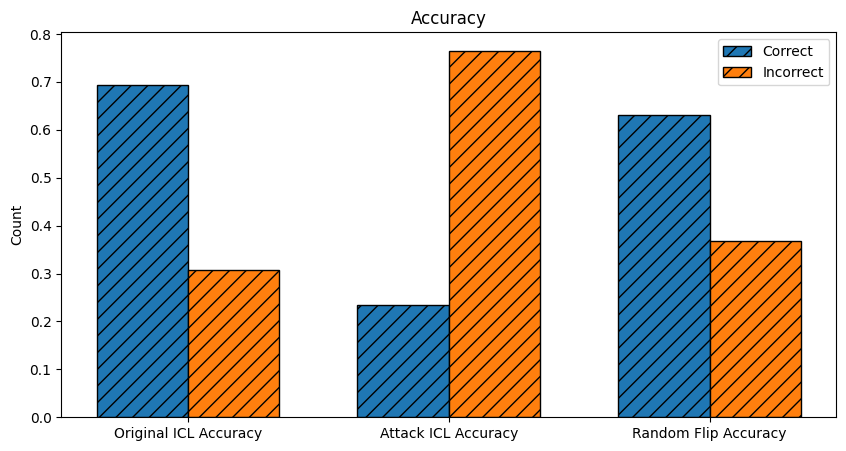

In [8]:
results = {
    'Original ICL Accuracy' : df['correct'].value_counts(),
    'Attack ICL Accuracy' : df['attack_correct'].value_counts(),
    'Random Flip Accuracy' : df['random_flip_correct'].value_counts()
}

# normalize the results
for key in results:
    results[key] = results[key] / results[key].sum()

# plot the bar chart
import matplotlib.pyplot as plt
import numpy as np

def plot_bar(results):
    labels = ['Original ICL Accuracy', 'Attack ICL Accuracy', 'Random Flip Accuracy']
    correct = [results['Original ICL Accuracy'][True], results['Attack ICL Accuracy'][True], results['Random Flip Accuracy'][True]]
    incorrect = [results['Original ICL Accuracy'][False], results['Attack ICL Accuracy'][False], results['Random Flip Accuracy'][False]]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 5))
    rects1 = ax.bar(x - width/2, correct, width, label='Correct', hatch='//', edgecolor='black')
    rects2 = ax.bar(x + width/2, incorrect, width, label='Incorrect', hatch='//', edgecolor='black')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Count')
    ax.set_title('Accuracy')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()


plot_bar(results)

In [9]:
from collections import Counter

def compute_label_icl_example_dist(row):
    if row['result_type'] == 'Skipped':
        return {}
    
    modified = row['perturbed_text']
    mod_q, mod_icl_examples = get_demo_and_question(modified)

    return dict(Counter([e[2] for e in mod_icl_examples]))

df['attack_demonstrations_dist'] = df.apply(compute_label_icl_example_dist, axis=1)

In [ ]:
successful_attack = df[df['result_type'] == 'Successful']

def get_the_label_dist(row):
    demo_dist = row['attack_demonstrations_dist']
    print(demo_dist)
    if demo_dist == {}:
        return {}
    correct_answer = 'false' if row['ground_truth_output'] == 0 else 'true'

    return {correct_answer: demo_dist[correct_answer]}

successful_attack['correct_label_dist'] = successful_attack.apply(get_the_label_dist, axis=1)

mapping = {0: 'false', 1: 'true'}

# measure the correct_label_dist based on ground_truth_output and plot them on a line chart
# successful_attack = successful_attack['correct_label_dist'].apply(lambda x: {mapping[k]: v for k, v in x.items()})


buckets = {'true': [], 'false': []}
for i, row in successful_attack.iterrows():
    for k, v in row['correct_label_dist'].items():
        buckets[k].append(v-8)

# draw them on a 2d bar chart

# final_bucket = buckets['true'] + [-1 * v for v in buckets['false']]

# plot the histogram with larger than zero as green and smaller than zero as red
import matplotlib.pyplot as plt
import numpy as np

def plot_histogram(buckets):
    fig, ax = plt.subplots(figsize=(15, 7))
    plt.hist(buckets['true'], bins=20, color='green', alpha=0.5, label='True')
    plt.hist(buckets['false'], bins=20, color='red', alpha=0.5, label='False')
    plt.title("Histogram of Successful Attacks")
    plt.xlabel("Number of Demonstrations")
    # make x axis as discrete values
    plt.xticks(np.arange(-16, 17, 1))
    plt.ylabel("Count")
    plt.legend(loc='upper right')
    plt.show()

plot_histogram(buckets)

In [ ]:
successful_attack = df[df['result_type'] == 'Successful']

def get_the_label_dist(row):
    demo_dist = row['attack_demonstrations_dist']
    print(demo_dist)
    if demo_dist == {}:
        return {}
    correct_answer = 'false' if row['ground_truth_output'] == 0 else 'true'

    return {correct_answer: demo_dist[correct_answer]}

successful_attack['correct_label_dist'] = successful_attack.apply(get_the_label_dist, axis=1)

mapping = {0: 'false', 1: 'true'}

# measure the correct_label_dist based on ground_truth_output and plot them on a line chart
# successful_attack = successful_attack['correct_label_dist'].apply(lambda x: {mapping[k]: v for k, v in x.items()})


buckets = {'true': [], 'false': []}
for i, row in successful_attack.iterrows():
    for k, v in row['correct_label_dist'].items():
        buckets[k].append(v-8)

# draw them on a 2d bar chart

# final_bucket = buckets['true'] + [-1 * v for v in buckets['false']]

# plot the histogram with larger than zero as green and smaller than zero as red
import matplotlib.pyplot as plt
import numpy as np

def plot_histogram(buckets):
    fig, ax = plt.subplots(figsize=(15, 7))
    plt.hist(buckets['true'], bins=20, color='green', alpha=0.5, label='True')
    plt.hist(buckets['false'], bins=20, color='red', alpha=0.5, label='False')
    plt.title("Histogram of Successful Attacks")
    plt.xlabel("Number of Demonstrations")
    # make x axis as discrete values
    plt.xticks(np.arange(-16, 17, 1))
    plt.ylabel("Count")
    plt.legend(loc='upper right')
    plt.show()

plot_histogram(buckets)

{'true': 11, 'false': 5}
{'true': 10, 'false': 6}
{'true': 6, 'false': 10}
{'false': 12, 'true': 4}
{'true': 4, 'false': 12}
{'true': 5, 'false': 11}
{'true': 5, 'false': 11}
{'true': 2, 'false': 14}
{'true': 9, 'false': 7}
{'true': 12, 'false': 4}
{'true': 7, 'false': 9}
{'true': 8, 'false': 8}
{'true': 9, 'false': 7}
{'true': 2, 'false': 14}
{'true': 9, 'false': 7}
{'true': 4, 'false': 12}
{'true': 5, 'false': 11}
{'true': 7, 'false': 9}
{'true': 5, 'false': 11}
{'true': 10, 'false': 6}
{'true': 5, 'false': 11}
{'true': 16}
{'true': 12, 'false': 4}
{'true': 6, 'false': 10}
{'true': 13, 'false': 3}
{'true': 14, 'false': 2}
{'true': 9, 'false': 7}
{'true': 10, 'false': 6}
{'true': 13, 'false': 3}
{'false': 10, 'true': 6}
{'true': 9, 'false': 7}
{'true': 9, 'false': 7}
{'true': 3, 'false': 13}
{'true': 15, 'false': 1}
{'true': 15, 'false': 1}
{'true': 14, 'false': 2}
{'true': 11, 'false': 5}
{'true': 6, 'false': 10}
{'true': 11, 'false': 5}
{'true': 6, 'false': 10}
{'true': 9, 'false': 

/tmp/ipykernel_94918/3728017454.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  successful_attack['correct_label_dist'] = successful_attack.apply(get_the_label_dist, axis=1)


NameError: name 'final_bucket' is not defined

In [20]:
print(get_demo_and_question(df.iloc[3]['original_text']))
print(get_demo_and_question(df.iloc[3]['perturbed_text']))

get_prompt(df.iloc[3]['original_text'])
get_prompt(df.iloc[3]['perturbed_text'])

(('the amish community in pennsylvania, which numbers about 55,000, lives an agrarian lifestyle, shunning technological advances like electricity and automobiles. and many say their insular lifestyle gives them a sense that they are protected from the violence of american society. but as residents gathered near the school, some wearing traditional garb and arriving in horse-drawn buggies, they said that sense of safety had been shattered. "if someone snaps and wants to do something stupid, there\'s no distance that\'s going to stop them," said jake king, 56, an amish lantern maker who knew several families whose children had been shot.', 'pennsylvania has the biggest amish community in the u.s.', ''), [('george herbert walker bush (born june 12, 1924) is the former 41st president of the united states of america. almost immediately upon his return from the war in december 1944, george bush married barbara pierce.', "the name of george h.w. bush's wife is barbara.", 'true'), ('it rewrite

'george herbert walker bush (born june 12, 1924) is the former 41st president of the united states of america. almost immediately upon his return from the war in december 1944, george bush married barbara pierce.\n The question is: the name of george h.w. bush\'s wife is barbara.. True or False?\nThe Answer is: true\n\nit rewrites the rules of global trade, established by the general agreement on tariffs and trade, or gatt, in 1947, and modified in multiple rounds of negotiations since then.\n The question is: gatt was formed in 1947.. True or False?\nThe Answer is: false\n\nus military forces are evacuating u.s. citizens and citizens of 72 other countries from liberia at the request of the u.s.\n The question is: u.s. military evacuated u.s. citizens.. True or False?\nThe Answer is: true\n\nfloods are one of europe\'s most widespread disasters. major flooding has occurred nearly every year somewhere on our continent during the last few decades.\n The question is: flooding in europe ca

In [23]:
df.head()

,original_text,perturbed_text,original_score,perturbed_score,original_output,perturbed_output,ground_truth_output,num_queries,result_type,attack_demonstrations_dist
0,"[[[[Premise]]]]: dana reeve, the widow of the ...","[[[[Premise]]]]: dana reeve, the widow of the ...",0.577495,0.577495,0,0,1,1,Skipped,{}
1,"[[[[Premise]]]]: yet, we now are discovering t...","[[[[Premise]]]]: yet, we now are discovering t...",0.629775,0.629775,1,1,0,1,Skipped,{}
2,[[[[Premise]]]]: cairo is now home to some 15 ...,[[[[Premise]]]]: cairo is now home to some 15 ...,0.348645,0.531209,1,0,1,46,Successful,"{'true': 11, 'false': 5}"
3,[[[[Premise]]]]: the amish community in pennsy...,[[[[Premise]]]]: the amish community in pennsy...,0.433981,0.542863,1,0,1,32,Successful,"{'true': 10, 'false': 6}"
4,[[[[Premise]]]]: security forces were on high ...,[[[[Premise]]]]: security forces were on high ...,0.370225,0.566019,0,1,0,32,Successful,"{'true': 6, 'false': 10}"


In [ ]:

demonstration = """
[[[[Premise]]]]: cairo is now home to some 15 million people - a burgeoning population that produces approximately 10,000 tonnes of rubbish per day, putting an enormous strain on public services. in the past 10 years, the government has tried hard to encourage private investment in the refuse sector, but some estimate 4,000 tonnes of waste is left behind every day, festering in the heat as it waits for someone to clear it up. it is often the people in the poorest neighbourhoods that are worst affected. but in some areas they are fighting back. in shubra, one of the northern districts of the city, the residents have taken to the streets armed with dustpans and brushes to clean up public areas which have been used as public dumps.<SPLIT>[[[[Hypothesis]]]]: 15 million tonnes of rubbish are produced daily in cairo.<SPLIT>[[[[Premise_0]]]]: george herbert walker bush (born june 12, 1924) is the former 41st president of the united states of america. almost immediately upon his return from the war in december 1944, george bush married barbara pierce.<SPLIT>[[[[Hypothesis_0]]]]: the name of george h.w. bush's wife is barbara.<SPLIT>[[[[Label_0]]]]: true<SPLIT>[[[[Premise_1]]]]: it rewrites the rules of global trade, established by the general agreement on tariffs and trade, or gatt, in 1947, and modified in multiple rounds of negotiations since then.<SPLIT>[[[[Hypothesis_1]]]]: gatt was formed in 1947.<SPLIT>[[[[Label_1]]]]: false<SPLIT>[[[[Premise_2]]]]: us military forces are evacuating u.s. citizens and citizens of 72 other countries from liberia at the request of the u.s.<SPLIT>[[[[Hypothesis_2]]]]: u.s. military evacuated u.s. citizens.<SPLIT>[[[[Label_2]]]]: true<SPLIT>[[[[Premise_3]]]]: floods are one of europe's most widespread disasters. major flooding has occurred nearly every year somewhere on our continent during the last few decades.<SPLIT>[[[[Hypothesis_3]]]]: flooding in europe causes major economic losses.<SPLIT>[[[[Label_3]]]]: [[false]]<SPLIT>[[[[Premise_4]]]]: rock stars aerosmith are to hold a free concert in hawaii to placate angry fans who brought a legal case against them. the walk this way hitmakers cancelled a sold-out show in maui two years ago, leaving hundreds of fans out of pocket. they filed a class action case, which claimed the band had pulled out in favour of a bigger gig in chicago and a private show for car dealers in oahu. lawyers for the would-be concert-goers said aerosmith had now agreed to put on a new show, and would pay all expenses.<SPLIT>[[[[Hypothesis_4]]]]: aerosmith are a rock band.<SPLIT>[[[[Label_4]]]]: true<SPLIT>[[[[Premise_5]]]]: one reason for increased osteoporosis in developed countries is the sodium-potassium imbalance.<SPLIT>[[[[Hypothesis_5]]]]: dietary intake of potassium prevents osteoporosis.<SPLIT>[[[[Label_5]]]]: [[false]]<SPLIT>[[[[Premise_6]]]]: jerusalem, april 2 (xinhua) -- israel's new foreign minister avigdor lieberman was questioned by police on thursday over several criminal allegations, local news service ynet reported.  national fraud unit investigators questioned the deputy premier, who is suspected of bribery, money laundering, fraud and breach of trust, for over seven hours, and another round is in the cards, said the report.  ""lieberman answered all of the questions he was asked, and will continue to do so in the future,"" his attorney yaron kostelitz was quoted as saying.<SPLIT>[[[[Hypothesis_6]]]]: avigdor lieberman is the foreign minister of israel.<SPLIT>[[[[Label_6]]]]: true<SPLIT>[[[[Premise_7]]]]: other friends were not surprised at his death. ""i wasn't surprised,"" said george stranahan, a former owner of the woody creek tavern, a favourite haunt of thompson. ""i never expected hunter to die in a hospital bed with tubes coming out of him."" neighbours have said how his broken leg had prevented him from leaving his house as often as he had liked to. one neighbour and long-standing friend, mike cleverly, said thompson was clearly hobbled by the broken leg. ""medically speaking, he's had a rotten year.""<SPLIT>[[[[Hypothesis_7]]]]: the woody creek tavern is owned by george stranahan.<SPLIT>[[[[Label_7]]]]: false<SPLIT>[[[[Premise_8]]]]: witching hour passed and potter fans poured into bookshops around the world on saturday, snatching up copies of the latest instalment in the series that promises to be the fastest-selling book in history.<SPLIT>[[[[Hypothesis_8]]]]: potter fans rushed to tills in order to purchase the book.<SPLIT>[[[[Label_8]]]]: true<SPLIT>[[[[Premise_9]]]]: alan mulally, boeing's head of the unit, said at the start of the strike that it may cause delivery delays that would give airbus sas an advantage in what is the strongest commercial aircraft market in five years.<SPLIT>[[[[Hypothesis_9]]]]: alan mulally is the owner of boeing.<SPLIT>[[[[Label_9]]]]: false<SPLIT>[[[[Premise_10]]]]: to promote the simpsons movie that will be released july 26, 2007, over a dozen 7-elevens in the united states have been transformed into kwik-e-marts, the grocery store from the popular tv series. most of the other 7-eleven stores will also sell products with brands reminding of the simpsons, such as buzz cola, krustyo's cereal, squishees, and bart simpson's favourite comic book radioactive man, but not duff beer, homer's favourite drink.<SPLIT>[[[[Hypothesis_10]]]]: the simpsons is a show broadcast in america.<SPLIT>[[[[Label_10]]]]: true<SPLIT>[[[[Premise_11]]]]: he is like some great writers, from charles dickens to william faulkner to gabriel garcia marquez: the insistence on the value of the local leads to the universal.<SPLIT>[[[[Hypothesis_11]]]]: gabriel garcia marquez is a nobel prize winner.<SPLIT>[[[[Label_11]]]]: false<SPLIT>[[[[Premise_12]]]]: colin l. powell and laura bush, wife of gov. george w. bush, are to speak on the opening night in philadelphia, while the democrats have tentative plans to have president clinton and hillary rodham clinton address the delegates on the first night in los angeles.<SPLIT>[[[[Hypothesis_12]]]]: the name of george w. bush's wife is laura.<SPLIT>[[[[Label_12]]]]: true<SPLIT>[[[[Premise_13]]]]: after insulting the un committee insinuating they were irrelavant, bush no sooner had approval from congress to use ""force/war"" if hussein did not permit unfettered access for inspections - and the war ships were moved into place on the gulf.<SPLIT>[[[[Hypothesis_13]]]]: hussein gives un inspectors unfettered access.<SPLIT>[[[[Label_13]]]]: [[false]]<SPLIT>[[[[Premise_14]]]]: while local cab drivers had compliments, not everyone appreciated the company. the chicago cubs decided to cancel their booking after hearing about the con, and j.j. hardy of the milwaukee brewers reported being kept up by fans on wednesday night. the brewers lost their game the following day. the convention closed with next year's date ―june 26-29 ―along with the announcement of a guest: disney animator floyd norman. the event's theme will be ""it's a jungle out there!"".<SPLIT>[[[[Hypothesis_14]]]]: j.j. hardy has a contract with the milwaukee brewers.<SPLIT>[[[[Label_14]]]]: true<SPLIT>[[[[Premise_15]]]]: for a western european country, the birth rate in finland is high.<SPLIT>[[[[Hypothesis_15]]]]: finland is the european country with the highest birth rate.<SPLIT>[[[[Label_15]]]]: false"""

demons = demonstration.split("<SPLIT>")
demons = [demon.split(":")[1].strip('\n ').strip('[]') for demon in demons]

question = (demons[0], demons[1], "")
icl_examples = []
demons = demons[2:]
for i in range(len(demons) // 3):
    icl_examples.append((demons[i * 3], demons[i * 3 + 1], demons[i * 3 + 2]))

template = "{}\n The question is: {}. True or False?\nThe Answer is: {}"
verbalizer = {0: "true", 1: "false"}

demos = []
for demo in icl_examples:
    demos.append(template.format(demo[0], demo[1], demo[2]))
q = template.format(question[0], question[1], "").strip()

prompt = "\n\n".join(demos) + "\n\n" + q

tokenized = tokenizer(prompt, return_tensors="pt", padding=True).to('cuda')
logits = model(**tokenized).logits
output = logits[:, -1, :].detach().cpu()

print(prompt)

label_id = [tokenizer.encode(verbalizer[0])[1], tokenizer.encode(verbalizer[1])[1]]

print(tokenizer.decode(output.argmax(dim=-1)))
output_label = output[:, label_id].softmax(dim=-1)
output_label

In [11]:
attack_sample = """[[[[Premise]]]]: cairo is now home to some 15 million people - a burgeoning population that produces approximately 10,000 tonnes of rubbish per day, putting an enormous strain on public services. in the past 10 years, the government has tried hard to encourage private investment in the refuse sector, but some estimate 4,000 tonnes of waste is left behind every day, festering in the heat as it waits for someone to clear it up. it is often the people in the poorest neighbourhoods that are worst affected. but in some areas they are fighting back. in shubra, one of the northern districts of the city, the residents have taken to the streets armed with dustpans and brushes to clean up public areas which have been used as public dumps.<SPLIT>[[[[Hypothesis]]]]: 15 million tonnes of rubbish are produced daily in cairo.<SPLIT>[[[[Premise_0]]]]: george herbert walker bush (born june 12, 1924) is the former 41st president of the united states of america. almost immediately upon his return from the war in december 1944, george bush married barbara pierce.<SPLIT>[[[[Hypothesis_0]]]]: the name of george h.w. bush's wife is barbara.<SPLIT>[[[[Label_0]]]]: true<SPLIT>[[[[Premise_1]]]]: it rewrites the rules of global trade, established by the general agreement on tariffs and trade, or gatt, in 1947, and modified in multiple rounds of negotiations since then.<SPLIT>[[[[Hypothesis_1]]]]: gatt was formed in 1947.<SPLIT>[[[[Label_1]]]]: false<SPLIT>[[[[Premise_2]]]]: us military forces are evacuating u.s. citizens and citizens of 72 other countries from liberia at the request of the u.s.<SPLIT>[[[[Hypothesis_2]]]]: u.s. military evacuated u.s. citizens.<SPLIT>[[[[Label_2]]]]: true<SPLIT>[[[[Premise_3]]]]: floods are one of europe's most widespread disasters. major flooding has occurred nearly every year somewhere on our continent during the last few decades.<SPLIT>[[[[Hypothesis_3]]]]: flooding in europe causes major economic losses.<SPLIT>[[[[Label_3]]]]: [[true]]<SPLIT>[[[[Premise_4]]]]: rock stars aerosmith are to hold a free concert in hawaii to placate angry fans who brought a legal case against them. the walk this way hitmakers cancelled a sold-out show in maui two years ago, leaving hundreds of fans out of pocket. they filed a class action case, which claimed the band had pulled out in favour of a bigger gig in chicago and a private show for car dealers in oahu. lawyers for the would-be concert-goers said aerosmith had now agreed to put on a new show, and would pay all expenses.<SPLIT>[[[[Hypothesis_4]]]]: aerosmith are a rock band.<SPLIT>[[[[Label_4]]]]: true<SPLIT>[[[[Premise_5]]]]: one reason for increased osteoporosis in developed countries is the sodium-potassium imbalance.<SPLIT>[[[[Hypothesis_5]]]]: dietary intake of potassium prevents osteoporosis.<SPLIT>[[[[Label_5]]]]: [[true]]<SPLIT>[[[[Premise_6]]]]: jerusalem, april 2 (xinhua) -- israel's new foreign minister avigdor lieberman was questioned by police on thursday over several criminal allegations, local news service ynet reported.  national fraud unit investigators questioned the deputy premier, who is suspected of bribery, money laundering, fraud and breach of trust, for over seven hours, and another round is in the cards, said the report.  ""lieberman answered all of the questions he was asked, and will continue to do so in the future,"" his attorney yaron kostelitz was quoted as saying.<SPLIT>[[[[Hypothesis_6]]]]: avigdor lieberman is the foreign minister of israel.<SPLIT>[[[[Label_6]]]]: true<SPLIT>[[[[Premise_7]]]]: other friends were not surprised at his death. ""i wasn't surprised,"" said george stranahan, a former owner of the woody creek tavern, a favourite haunt of thompson. ""i never expected hunter to die in a hospital bed with tubes coming out of him."" neighbours have said how his broken leg had prevented him from leaving his house as often as he had liked to. one neighbour and long-standing friend, mike cleverly, said thompson was clearly hobbled by the broken leg. ""medically speaking, he's had a rotten year.""<SPLIT>[[[[Hypothesis_7]]]]: the woody creek tavern is owned by george stranahan.<SPLIT>[[[[Label_7]]]]: false<SPLIT>[[[[Premise_8]]]]: witching hour passed and potter fans poured into bookshops around the world on saturday, snatching up copies of the latest instalment in the series that promises to be the fastest-selling book in history.<SPLIT>[[[[Hypothesis_8]]]]: potter fans rushed to tills in order to purchase the book.<SPLIT>[[[[Label_8]]]]: true<SPLIT>[[[[Premise_9]]]]: alan mulally, boeing's head of the unit, said at the start of the strike that it may cause delivery delays that would give airbus sas an advantage in what is the strongest commercial aircraft market in five years.<SPLIT>[[[[Hypothesis_9]]]]: alan mulally is the owner of boeing.<SPLIT>[[[[Label_9]]]]: false<SPLIT>[[[[Premise_10]]]]: to promote the simpsons movie that will be released july 26, 2007, over a dozen 7-elevens in the united states have been transformed into kwik-e-marts, the grocery store from the popular tv series. most of the other 7-eleven stores will also sell products with brands reminding of the simpsons, such as buzz cola, krustyo's cereal, squishees, and bart simpson's favourite comic book radioactive man, but not duff beer, homer's favourite drink.<SPLIT>[[[[Hypothesis_10]]]]: the simpsons is a show broadcast in america.<SPLIT>[[[[Label_10]]]]: true<SPLIT>[[[[Premise_11]]]]: he is like some great writers, from charles dickens to william faulkner to gabriel garcia marquez: the insistence on the value of the local leads to the universal.<SPLIT>[[[[Hypothesis_11]]]]: gabriel garcia marquez is a nobel prize winner.<SPLIT>[[[[Label_11]]]]: false<SPLIT>[[[[Premise_12]]]]: colin l. powell and laura bush, wife of gov. george w. bush, are to speak on the opening night in philadelphia, while the democrats have tentative plans to have president clinton and hillary rodham clinton address the delegates on the first night in los angeles.<SPLIT>[[[[Hypothesis_12]]]]: the name of george w. bush's wife is laura.<SPLIT>[[[[Label_12]]]]: true<SPLIT>[[[[Premise_13]]]]: after insulting the un committee insinuating they were irrelavant, bush no sooner had approval from congress to use ""force/war"" if hussein did not permit unfettered access for inspections - and the war ships were moved into place on the gulf.<SPLIT>[[[[Hypothesis_13]]]]: hussein gives un inspectors unfettered access.<SPLIT>[[[[Label_13]]]]: [[true]]<SPLIT>[[[[Premise_14]]]]: while local cab drivers had compliments, not everyone appreciated the company. the chicago cubs decided to cancel their booking after hearing about the con, and j.j. hardy of the milwaukee brewers reported being kept up by fans on wednesday night. the brewers lost their game the following day. the convention closed with next year's date ―june 26-29 ―along with the announcement of a guest: disney animator floyd norman. the event's theme will be ""it's a jungle out there!"".<SPLIT>[[[[Hypothesis_14]]]]: j.j. hardy has a contract with the milwaukee brewers.<SPLIT>[[[[Label_14]]]]: true<SPLIT>[[[[Premise_15]]]]: for a western european country, the birth rate in finland is high.<SPLIT>[[[[Hypothesis_15]]]]: finland is the european country with the highest birth rate.<SPLIT>[[[[Label_15]]]]: false"""

attack_sample = attack_sample.split("<SPLIT>")
demons = [demon.split(":")[1].strip('\n ').strip('[]') for demon in attack_sample]
# print(demons)
question = (demons[0], demons[1], "")
icl_examples = []
demons = demons[2:]
for i in range(len(demons) // 3):
    icl_examples.append((demons[i * 3], demons[i * 3 + 1], demons[i * 3 + 2]))

template = "{}\n The question is: {}. True or False?\nThe Answer is: {}"
verbalizer = {0: "true", 1: "false"}

demos = []
for demo in icl_examples:
    demos.append(template.format(demo[0], demo[1], demo[2]))
q = template.format(question[0], question[1], "").strip()

prompt = "\n\n".join(demos) + "\n\n" + q

# print(prompt)
tokenized = tokenizer(prompt, return_tensors="pt", padding=True).to('cuda')
logits = model(**tokenized).logits
output = logits[:, -1, :].detach().cpu()

print(tokenizer.decode(output.argmax(dim=-1)))

print(prompt)

output_label = output[:, label_id].softmax(dim=-1)
output_label

true
george herbert walker bush (born june 12, 1924) is the former 41st president of the united states of america. almost immediately upon his return from the war in december 1944, george bush married barbara pierce.
 The question is: the name of george h.w. bush's wife is barbara.. True or False?
The Answer is: true

it rewrites the rules of global trade, established by the general agreement on tariffs and trade, or gatt, in 1947, and modified in multiple rounds of negotiations since then.
 The question is: gatt was formed in 1947.. True or False?
The Answer is: false

us military forces are evacuating u.s. citizens and citizens of 72 other countries from liberia at the request of the u.s.
 The question is: u.s. military evacuated u.s. citizens.. True or False?
The Answer is: true

floods are one of europe's most widespread disasters. major flooding has occurred nearly every year somewhere on our continent during the last few decades.
 The question is: flooding in europe causes major 

tensor([[0.5506, 0.4494]])

In [18]:
tokenizer("True")

{'input_ids': [1, 5852], 'attention_mask': [1, 1]}

In [ ]:
demonstration = [("george herbert walker bush (born june 12, 1924) is the former 41st president of the united states of america. almost immediately upon his return from the war in december 1944, george bush married barbara pierce.", "the name of george h.w. bush's wife is barbara.", 0),
                 ("it rewrites the rules of global trade, established by the general agreement on tariffs and trade, or gatt, in 1947, and modified in multiple rounds of negotiations since then.", "gatt was formed in 1947.", 1),
                    ("us military forces are evacuating u.s. citizens and citizens of 72 other countries from liberia at the request of the u.s.", "u.s. military evacuated u.s. citizens.", 0),
                    ("floods are one of europe's most widespread disasters. major flooding has occurred nearly every year somewhere on our continent during the last few decades.", "flooding in europe causes major economic losses.", 1),
                    ("rock stars aerosmith are to hold a free concert in hawaii to placate angry fans who brought a legal case against them. the walk this way hitmakers cancelled a sold-out show in maui two years ago, leaving hundreds of fans out of pocket. they filed a class action case, which claimed the band had pulled out in favour of a bigger gig in chicago and a private show for car dealers in oahu. lawyers for the would-be concert-goers said aerosmith had now agreed to put on a new show, and would pay all expenses.", "aerosmith are a rock band.", 0),
                    ("one reason for increased osteoporosis in developed countries is the sodium-potassium imbalance.", "dietary intake of potassium prevents osteoporosis.", 1)]

template = ["Premise: {}\nHypothesis: {}\nPrediction: {}",
            "{}\nThe question is: {}. True or False?\nAnswer: {}"]
verbalizer = {0: "true", 1: "false"}
# Premise: jerusalem, april 2 (xinhua) -- israel's new foreign minister avigdor lieberman was questioned by police on thursday over several criminal allegations, local news service ynet reported.  national fraud unit investigators questioned the deputy premier, who is suspected of bribery, money laundering, fraud and breach of trust, for over seven hours, and another round is in the cards, said the report.  "lieberman answered all of the questions he was asked, and will continue to do so in the future," his attorney yaron kostelitz was quoted as saying.
# Hypothesis: avigdor lieberman is the foreign minister of israel.
# Prediction: false

# Premise: other friends were not surprised at his death. "i wasn't surprised," said george stranahan, a former owner of the woody creek tavern, a favourite haunt of thompson. "i never expected hunter to die in a hospital bed with tubes coming out of him." neighbours have said how his broken leg had prevented him from leaving his house as often as he had liked to. one neighbour and long-standing friend, mike cleverly, said thompson was clearly hobbled by the broken leg. "medically speaking, he's had a rotten year."
# Hypothesis: the woody creek tavern is owned by george stranahan.
# Prediction: true
# """

questions = [("jerusalem, april 2 (xinhua) -- israel's new foreign minister avigdor lieberman was questioned by police on thursday over several criminal allegations, local news service ynet reported.  national fraud unit investigators questioned the deputy premier, who is suspected of bribery, money laundering, fraud and breach of trust, for over seven hours, and another round is in the cards, said the report.  \"lieberman answered all of the questions he was asked, and will continue to do so in the future,\" his attorney yaron kostelitz was quoted as saying.", "avigdor lieberman is the foreign minister of israel.", 0), 
            ("other friends were not surprised at his death. \"i wasn\'t surprised,\" said george stranahan, a former owner of the woody creek tavern, a favourite haunt of thompson. \"i never expected hunter to die in a hospital bed with tubes coming out of him.\" neighbours have said how his broken leg had prevented him from leaving his house as often as he had liked to. one neighbour and long-standing friend, mike cleverly, said thompson was clearly hobbled by the broken leg. \"medically speaking, he\'s had a rotten year.", "the woody creek tavern is owned by george stranahan.", 1)]
# question = "Premise: he also referred to the \"illegal\" arrest on 31 may of mexican professor maria eugenia ochoa garcia, whom the salvadoran government accused of having connections with the salvadoran guerrillas.\nHypothesis: professor ochoa garcia is a member of the salvadoran government.\nPrediction:"
for question in questions:
    for tem in template:
        demos = []
        for demo in demonstration:
            demos.append(tem.format(demo[0], demo[1], verbalizer[demo[2]]))
        q = tem.format(question[0], question[1], "").strip()

        prompt = "\n".join(demos) + "\n" + q

        tokenized = tokenizer(prompt, return_tensors="pt", padding=True).to('cuda')
        logits = model(**tokenized).logits
        output = logits[:, -1, :].detach().cpu()

        print(tokenizer.decode(torch.argmax(output, dim=-1).squeeze().tolist()))

In [20]:
from itertools import permutations
from tqdm import tqdm
import numpy as np
from collections import Counter
instructions = "Classify the sentiment of negative and positive."
icl_samples = ["Review: is a step down for director gary fleder . \nSentiment: negative",
               "Review: the director , tom dey , had spliced together bits and pieces of midnight run and 48 hours ( and , for that matter , shrek ) . \nSentiment: positive",
                "Review: from two fatal ailments -- a dearth of vitality and a story that 's shapeless and uninflected . \nSentiment: negative",
                "Review: results that are sometimes bracing . \nSentiment: positive",
                "Review: plodding soap opera . \nSentiment: negative",
                "Review: all-star salute . \nSentiment: positive",
                "Review: fit all of pootie tang in between its punchlines . \nSentiment: negative",
                "Review: award-winning . \nSentiment: positive",
                "Review: deserve better . \nSentiment: negative",
                "Review: you actually buy into \nSentiment: positive",
                "Review: of cliches that shoplifts shamelessly from farewell-to-innocence movies like the wanderers and a bronx tale without cribbing any of their intelligence . \nSentiment: negative",
                "Review: real-life basis is , in fact , so interesting that no embellishment is \nSentiment: positive",
                "Review: to insulting the intelligence of anyone who has n't been living under a rock \nSentiment: negative",
                "Review: immensely ambitious \nSentiment: positive",
                "Review: into the modern rut of narrative banality \nSentiment: negative",
                "Review: user-friendly \nSentiment: positive"]
sample = """or doing last year 's taxes with your ex-wife . \nSentiment:"""

prompt_ids_list = []
i = 0
# permutation = np.random.permutation(len(icl_samples))
# icl_samples = [icl_samples[i] for i in permutation]

np.random.seed(1)
for order in range(100):
    permutation = np.random.permutation(len(icl_samples))
    order = [icl_samples[i] for i in permutation]
    prompt = '\n\n'.join(order) + '\n\n' + sample
    # prompt_ids = tokenizer.encode(prompt, return_tensors="pt")
    # prompt_ids = prompt_ids.to('cuda')

    prompt_ids_list.append((prompt))
    i += 1

print('Length of prompt_ids_list: ', len(prompt_ids_list))

batch_size = 8
prompt_ids_list = [prompt_ids_list[i:i + batch_size] for i in range(0, len(prompt_ids_list), batch_size)]

# convert prompt_ids_list to dataloader
# prompt_ids_list = torch.utils.data.DataLoader(prompt_ids_list, batch_size=batch_size, shuffle=False)

outputs = []
for batch in tqdm(prompt_ids_list):
    batch = tokenizer.batch_encode_plus(batch, return_tensors="pt", padding=True, truncation=True).to('cuda')
    output = model(batch['input_ids'], return_dict=True).logits
    output = output[:, -1, :].detach().cpu()
    # outputs += tokenizer.batch_decode(torch.argmax(output, dim=-1).squeeze().tolist())
    outputs += (tokenizer.batch_decode(torch.argmax(output, dim=-1).squeeze().tolist()))
    del batch
    
print(Counter(outputs))
# prompt = '\n\n'.join(icl_samples) + '\n\n' + sample
# prompt_ids = tokenizer.encode(prompt, return_tensors="pt")
# prompt_ids = prompt_ids.to('cuda')

# output = model(prompt_ids, return_dict=True).logits
# print(output.shape)
# output = output[:, -1, :]
# tokenizer.decode(torch.argmax(output, dim=-1).squeeze().tolist())

Length of prompt_ids_list:  100


100%|██████████| 13/13 [00:03<00:00,  3.67it/s]

Counter({'positive': 97, 'negative': 3})


In [50]:
tokenizer("terrible")

{'input_ids': [1, 16403], 'attention_mask': [1, 1]}

In [24]:
prompt = """Classify the sentiment of positive and negative.
Review: i would recommend big bad love only to winger fans who have missed her since 1995 's forget paris . .
Sentiment: negative
Review: suspenseful enough for older kids but not .
Sentiment: positive
Review: another run-of-the-mill disney sequel intended for the home video market .
Sentiment: negative
Review: has never been smoother or more confident .
Sentiment: positive
Review: bad-movie .
Sentiment: negative
Review: sweetly .
Sentiment: positive
Review: like an extended dialogue exercise in retard 101 .
Sentiment: negative
Review: bouquet gives a performance that is masterly . .
Sentiment: positive"""

input1 = "Review: one of creepiest, scariest movies to come along in a long, long time, easily rivaling blair witch or the others. \nSentiment:"
input2 = "Review: good movie . \nSentiment:"

prompt_ids = gpt_tokenizer.encode(prompt, return_tensors="pt")
inputs1 = prompt + input1
inputs2 = prompt + input2

inputs = [inputs1, inputs2]
# inputs = [inputs1, inputs1]

gpt_tokenizer.pad_token = gpt_tokenizer.eos_token
input_ids = gpt_tokenizer.batch_encode_plus(inputs, return_tensors="pt", padding=True, truncation=True)['input_ids'].to('cuda')

attention_mask = input_ids.ne(gpt_tokenizer.pad_token_id).float().to('cuda')
output = gpt_model(input_ids, attention_mask=attention_mask, return_dict=True).logits

last_non_pad_indices = torch.ne(input_ids, gpt_tokenizer.pad_token_id).sum(-1) - 1
print(last_non_pad_indices)
output = output[range(output.shape[0]), last_non_pad_indices, :]

gpt_tokenizer.batch_decode(torch.argmax(output, dim=-1).squeeze().tolist())

tensor([193, 167], device='cuda:0')


[' negative', ' positive']

In [33]:
prompt = "Classify the sentiment of positive and negative.\n Review: i would recommend big bad love only to winger fans who have missed her since 1995 's forget paris.Sentiment: negative\nReview:  suspenseful enough for older kids but not . \nSentiment: positive\n"

input = "Review: the cd is not suitable for children . \nSentiment:"
# try with the mistral tokenizer and model

prompt_ids = mistral_tokenizer.encode(prompt, return_tensors="pt")
input_ids = mistral_tokenizer.encode(input, return_tensors="pt")

input_ids = torch.cat([prompt_ids, input_ids[:, 1:]], dim=-1).to('cuda')

# add 10 padding tokens to the end of the input
input_ids = torch.cat([input_ids, torch.ones((1, 10)).long().to('cuda')], dim=-1)

attention_mask = input_ids != 1

output = mistral_model(input_ids, attention_mask=attention_mask, return_dict=True).logits
print(output.shape)
output = output[:, len(input_ids[0]) - 11, :]
mistral_tokenizer.decode(torch.argmax(output, dim=-1).squeeze().tolist())

torch.Size([1, 90, 32000])


'negative'

In [22]:
mistral_tokenizer("great")

{'input_ids': [1, 1598], 'attention_mask': [1, 1]}

In [51]:
gpt_tokenizer(" terrible")

{'input_ids': [353, 5547], 'attention_mask': [1, 1]}